In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier

from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.metrics import classification_report, f1_score, confusion_matrix

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import matplotlib.style as style
style.use("seaborn-darkgrid")

pd.set_option('display.max_columns', None)

from sys import path 
path.insert(0, 'D:/python/PROJECTS/GIT/ML-Basic/')

# About dataset

### basic info

In [2]:
# importing data
df=pd.read_csv('TelcoChurn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


**there are a lot of features**

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
df.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

**seems like no missing values**

### dropping high variance feature 'customerID'

In [5]:
df.drop('customerID', axis=1, inplace=True)

### converting 'SeniorCitizen' column to object for easy categorical column handling

In [6]:
df.SeniorCitizen=df.SeniorCitizen.astype('object')

### extracting numerical columns

In [7]:
columns_num=list(df.describe().columns)
columns_num

['tenure', 'MonthlyCharges', 'TotalCharges']

### extracting categorical columns

In [8]:
columns_cate=[ col for col in df.columns if col not in columns_num ]
columns_cate.remove('Churn')
columns_cate

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

### Data Dictionary

In [9]:
# making description column
description=['Whether the customer is a male or a female',
             'Whether the customer is a senior citizen or not',
             'Whether the customer has a partner or not',
             'Whether the customer has dependents or not ',
             'Number of months the customer has stayed with the company/duration of subscription',
             'Whether the customer has a phone service or not',
             'Whether the customer has multiple lines or not',
             'Customer’s internet service provider',
             'Whether the customer has online security or not',
             'Whether the customer has online backup or not',
             'Whether the customer has device protection or not',
             'Whether the customer has tech support or not',
             'Whether the customer has streaming TV or not',
             'Whether the customer has streaming movies or not',
             'The contract term of the customer/subscription type',
             'Whether the customer has paperless billing or not',
             'The customer’s payment method',
             'The amount charged to the customer monthly',
             'The total amount charged to the customer',
             'Whether the customer churned or not'
            ]

# making key column
key=[list( df[col].unique() ) if col in columns_cate else [''] for col in df.columns ]

dict1={'Feature':df.columns,
       'Description':description,
       'Key':key
      }

data_dict=pd.DataFrame(dict1).set_index('Feature')

# adding key for 'SeniorCitizen' and 'Churn' variables
data_dict.loc[['SeniorCitizen','Churn'], 'Key'] = '0=No, 1=Yes'

data_dict

,Description,Key
Feature,,
gender,Whether the customer is a male or a female,"[Female, Male]"
SeniorCitizen,Whether the customer is a senior citizen or not,"0=No, 1=Yes"
Partner,Whether the customer has a partner or not,"[Yes, No]"
Dependents,Whether the customer has dependents or not,"[No, Yes]"
tenure,Number of months the customer has stayed with ...,[]
PhoneService,Whether the customer has a phone service or not,"[No, Yes]"
MultipleLines,Whether the customer has multiple lines or not,"[No phone service, No, Yes]"
InternetService,Customer’s internet service provider,"[DSL, Fiber optic, No]"
OnlineSecurity,Whether the customer has online security or not,"[No, Yes, No internet service]"


### label encoding the target variable "churn" and storing as target

In [10]:
df['target']=(df.Churn=='Yes').astype('int64')
df.target

0       0
1       0
2       1
3       0
4       1
       ..
7038    0
7039    0
7040    0
7041    1
7042    0
Name: target, Length: 7043, dtype: int64

In [11]:
df.drop(columns='Churn', axis=1, inplace=True)

# EDA

### getting churn rate

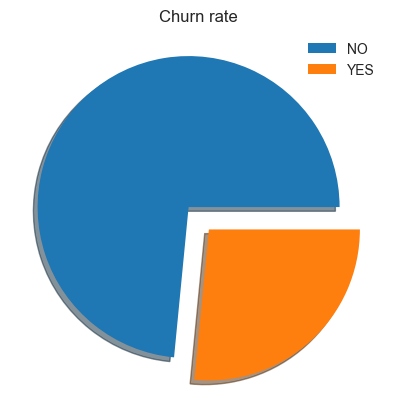

In [12]:
plt.figure(figsize=(5,5), dpi=100)
plt.pie(df.target.value_counts(), explode=[0.1,0.1], shadow=True)
plt.legend(['NO','YES'])
plt.title('Churn rate')
plt.show()

### **seems like we have an IMBALANCED class problem**

In [13]:
##################################
'''IMPORTING FROM CUSTOM MODULE'''
##################################
from quick_EDA import analysis_quant, analysis_cate, handle_outliers, correlation, multiplot 

### **UNIVARIATE ANALYSIS**

### analysing continuous features  

In [14]:
df.describe()

,tenure,MonthlyCharges,TotalCharges,target
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,32.371149,64.761692,2279.798992,0.265370
std,24.559481,30.090047,2266.730170,0.441561
min,0.000000,18.250000,18.800000,0.000000
25%,9.000000,35.500000,398.550000,0.000000
50%,29.000000,70.350000,1394.550000,0.000000
75%,55.000000,89.850000,3786.600000,1.000000
max,72.000000,118.750000,8684.800000,1.000000


				ANALYSIS OF: tenure 

5 point summary for: tenure
     tenure
min     0.0
25%     9.0
50%    29.0
75%    55.0
max    72.0
---------------------------------
OUTLIERS in tenure via Z score

Outlier limits:
lower limit: -41.30206361034809 
upper limit: 106.04436092683255

Total outliers: 0
---------------------------------
OUTLIERS in tenure via IQR

Outlier limits:
lower limit: -60.0 
upper limit: 124.0

Total outliers: 0
---------------------------------


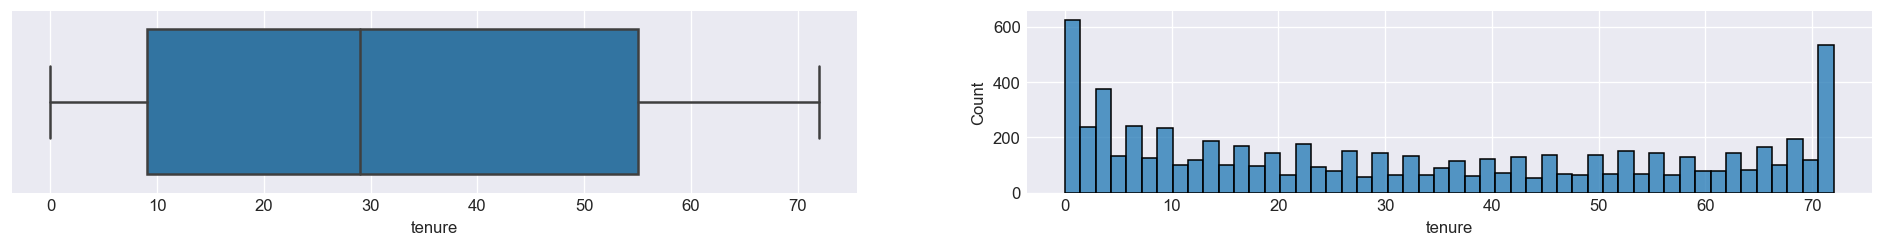

___________________________________________________________________________________________________________
				ANALYSIS OF: MonthlyCharges 

5 point summary for: MonthlyCharges
     MonthlyCharges
min           18.25
25%           35.50
50%           70.35
75%           89.85
max          118.75
---------------------------------
OUTLIERS in MonthlyCharges via Z score

Outlier limits:
lower limit: -25.502040104211744 
upper limit: 155.0254250254101

Total outliers: 0
---------------------------------
OUTLIERS in MonthlyCharges via IQR

Outlier limits:
lower limit: -46.02499999999999 
upper limit: 171.375

Total outliers: 0
---------------------------------


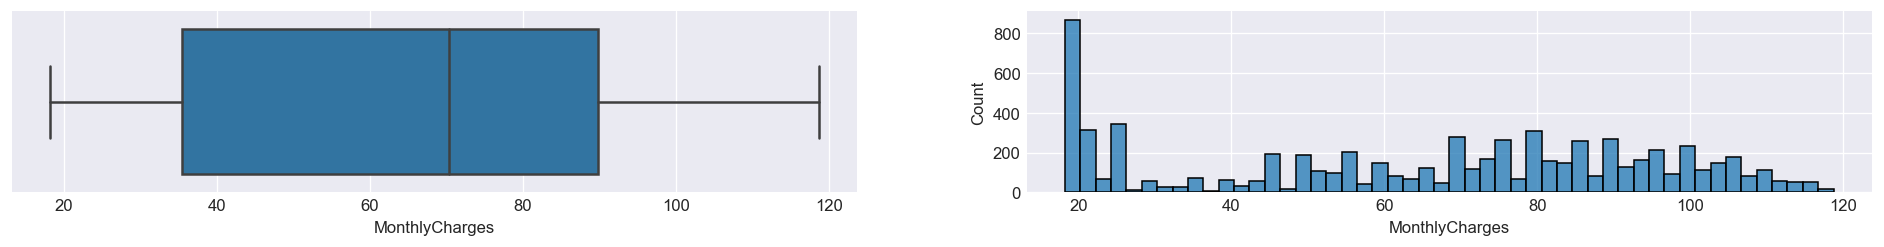

___________________________________________________________________________________________________________
				ANALYSIS OF: TotalCharges 

5 point summary for: TotalCharges
     TotalCharges
min         18.80
25%        398.55
50%       1394.55
75%       3786.60
max       8684.80
---------------------------------
OUTLIERS in TotalCharges via Z score

Outlier limits:
lower limit: -4519.9087384988725 
upper limit: 9079.50672231259

Total outliers: 0
---------------------------------
OUTLIERS in TotalCharges via IQR

Outlier limits:
lower limit: -4683.525 
upper limit: 8868.675

Total outliers: 0
---------------------------------


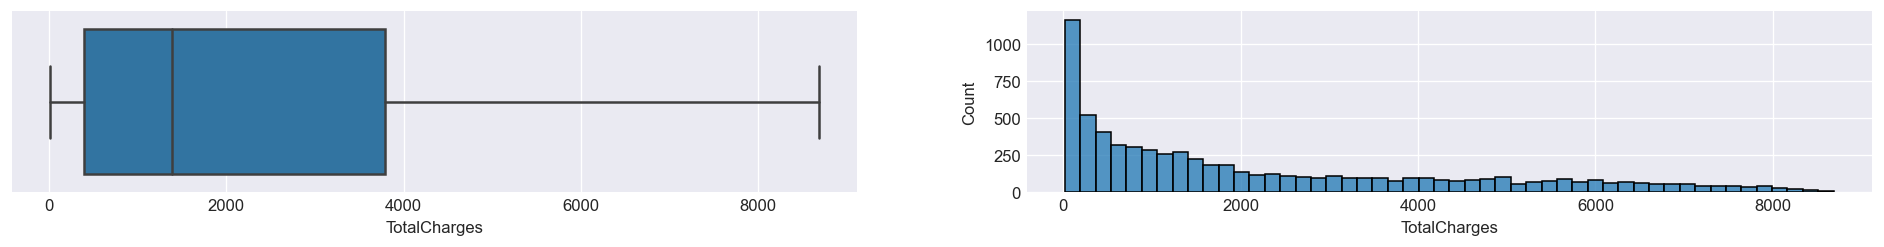

___________________________________________________________________________________________________________


In [15]:
analysis_quant(df, columns_num)

##### ***distribution doesnt seem to be normal for the numerical features***

### analysing discrete features

				ANALYSIS OF: gender 

No. of UNIQUE values:
Male      3555
Female    3488
Name: gender, dtype: int64



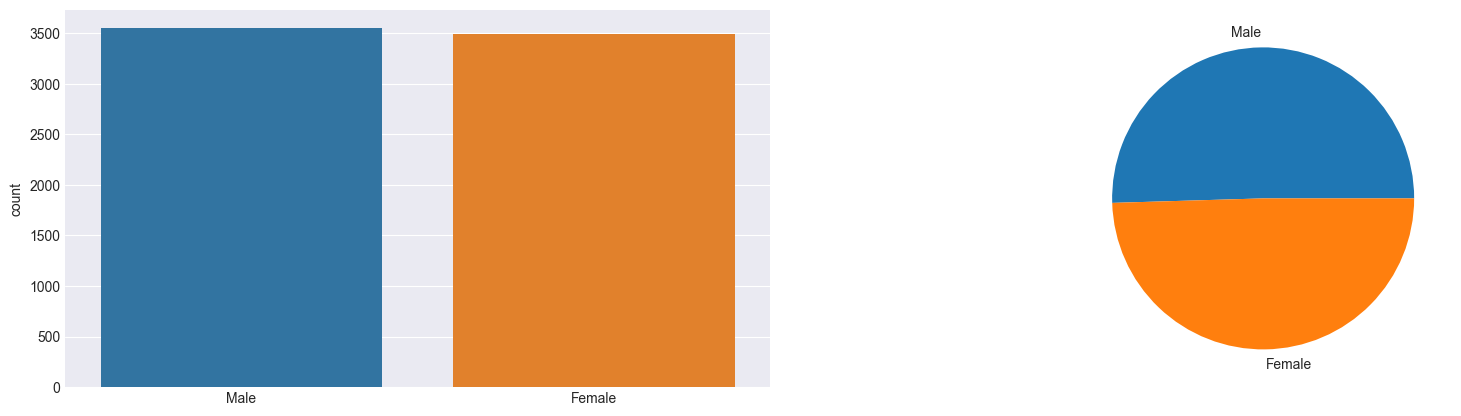

_____________________________________________________________________________________________________________________
				ANALYSIS OF: SeniorCitizen 

No. of UNIQUE values:
0    5901
1    1142
Name: SeniorCitizen, dtype: int64



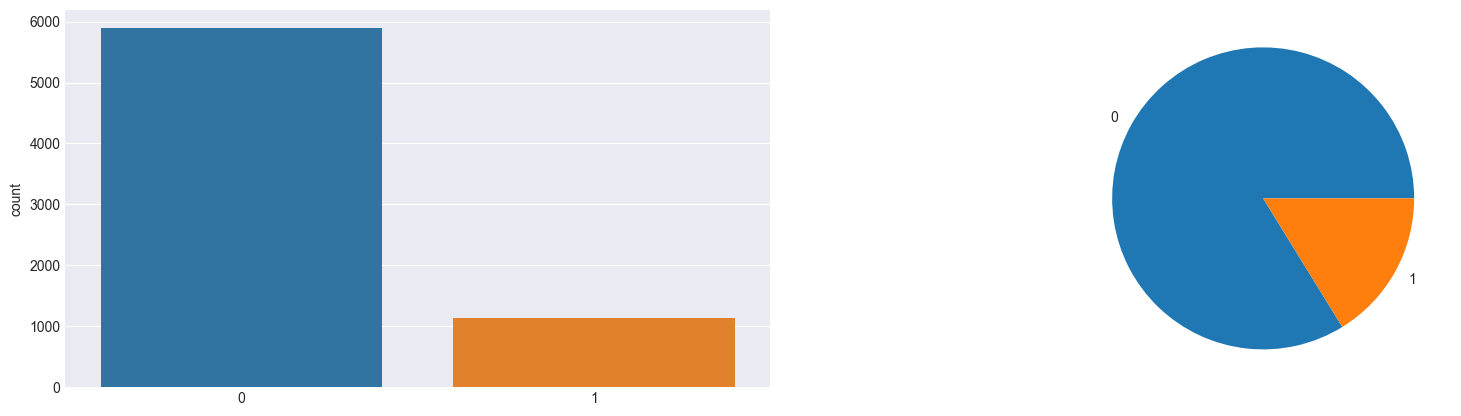

_____________________________________________________________________________________________________________________
				ANALYSIS OF: Partner 

No. of UNIQUE values:
No     3641
Yes    3402
Name: Partner, dtype: int64



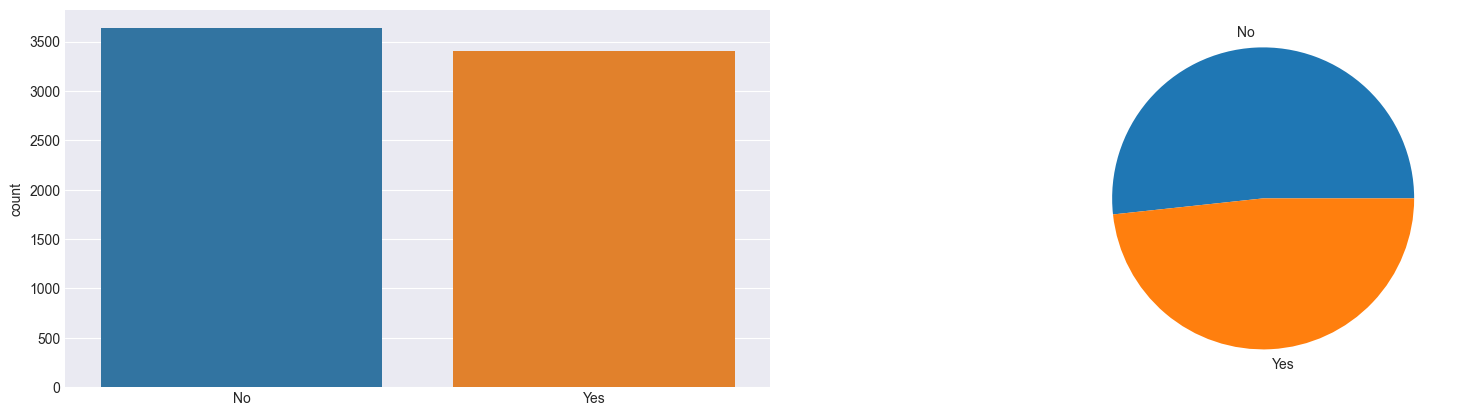

_____________________________________________________________________________________________________________________
				ANALYSIS OF: Dependents 

No. of UNIQUE values:
No     4933
Yes    2110
Name: Dependents, dtype: int64



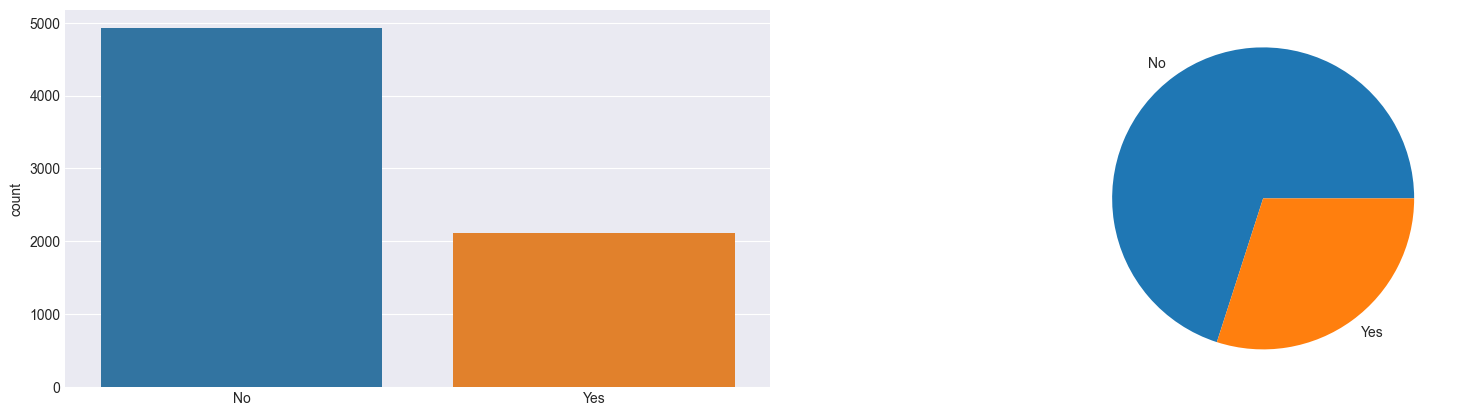

_____________________________________________________________________________________________________________________
				ANALYSIS OF: PhoneService 

No. of UNIQUE values:
Yes    6361
No      682
Name: PhoneService, dtype: int64



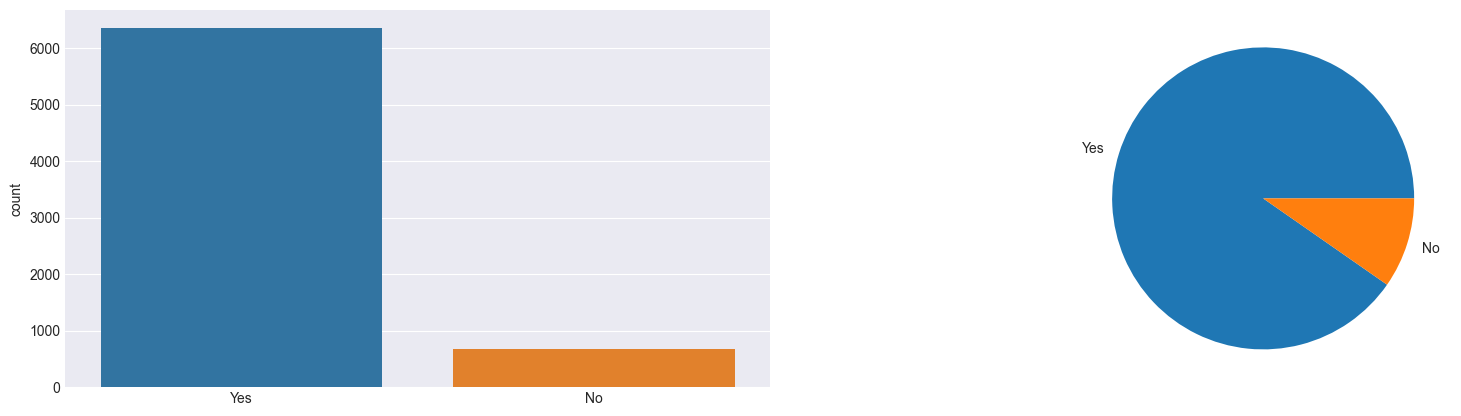

_____________________________________________________________________________________________________________________
				ANALYSIS OF: MultipleLines 

No. of UNIQUE values:
No                  3390
Yes                 2971
No phone service     682
Name: MultipleLines, dtype: int64



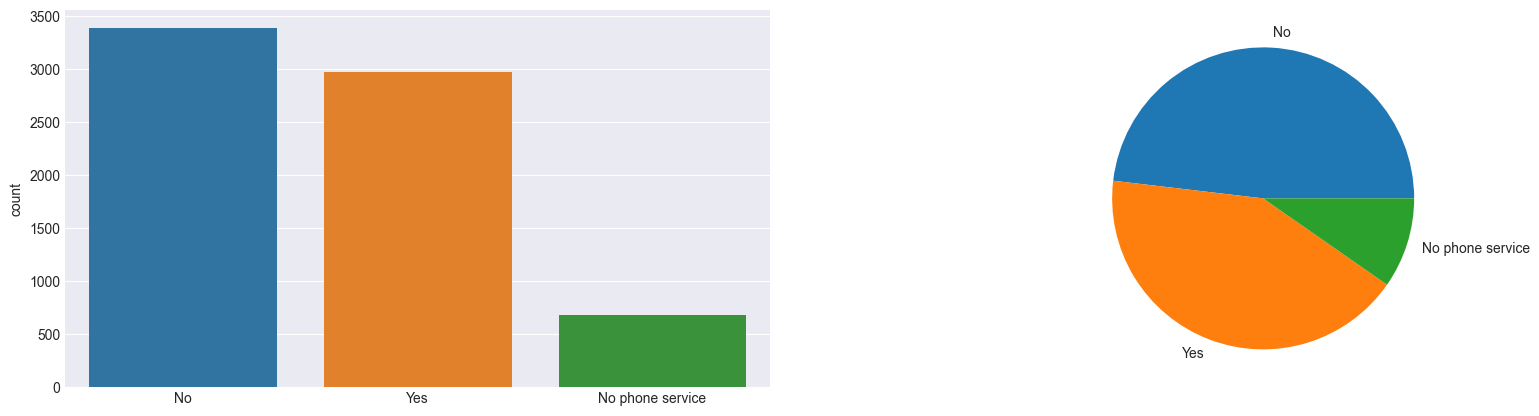

_____________________________________________________________________________________________________________________
				ANALYSIS OF: InternetService 

No. of UNIQUE values:
Fiber optic    3096
DSL            2421
No             1526
Name: InternetService, dtype: int64



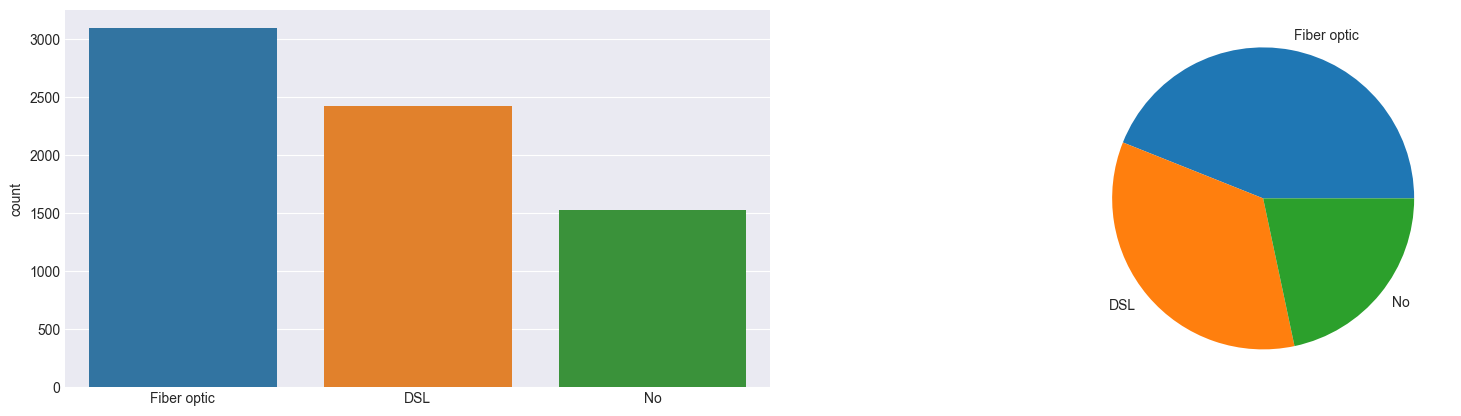

_____________________________________________________________________________________________________________________
				ANALYSIS OF: OnlineSecurity 

No. of UNIQUE values:
No                     3498
Yes                    2019
No internet service    1526
Name: OnlineSecurity, dtype: int64



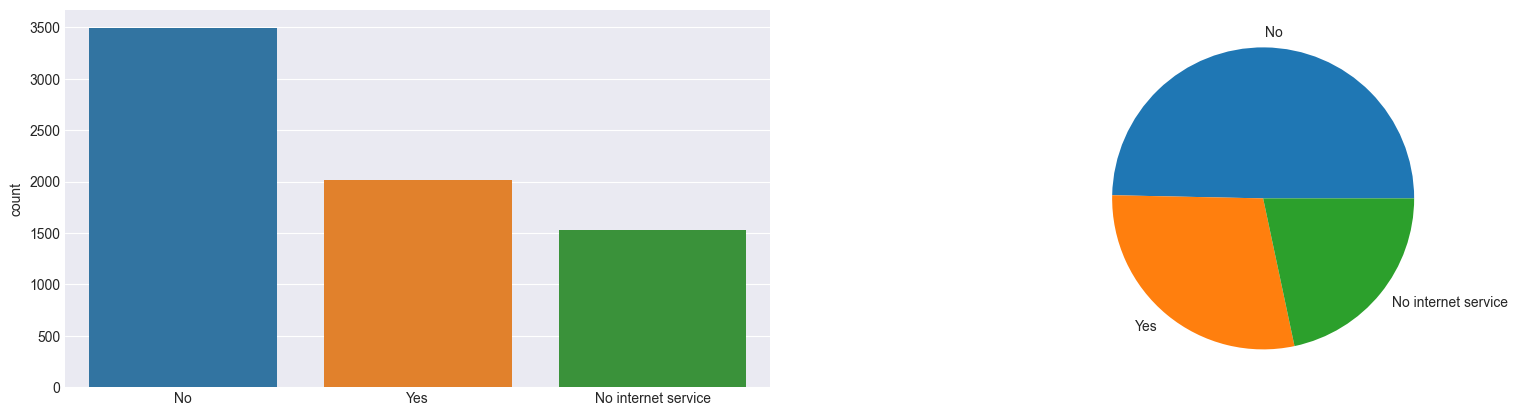

_____________________________________________________________________________________________________________________
				ANALYSIS OF: OnlineBackup 

No. of UNIQUE values:
No                     3088
Yes                    2429
No internet service    1526
Name: OnlineBackup, dtype: int64



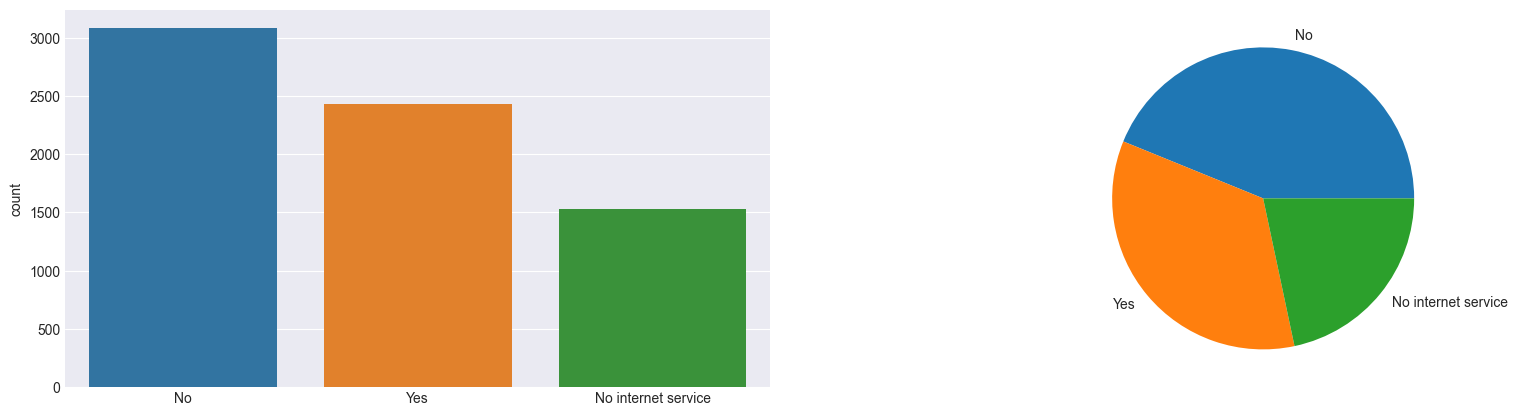

_____________________________________________________________________________________________________________________
				ANALYSIS OF: DeviceProtection 

No. of UNIQUE values:
No                     3095
Yes                    2422
No internet service    1526
Name: DeviceProtection, dtype: int64



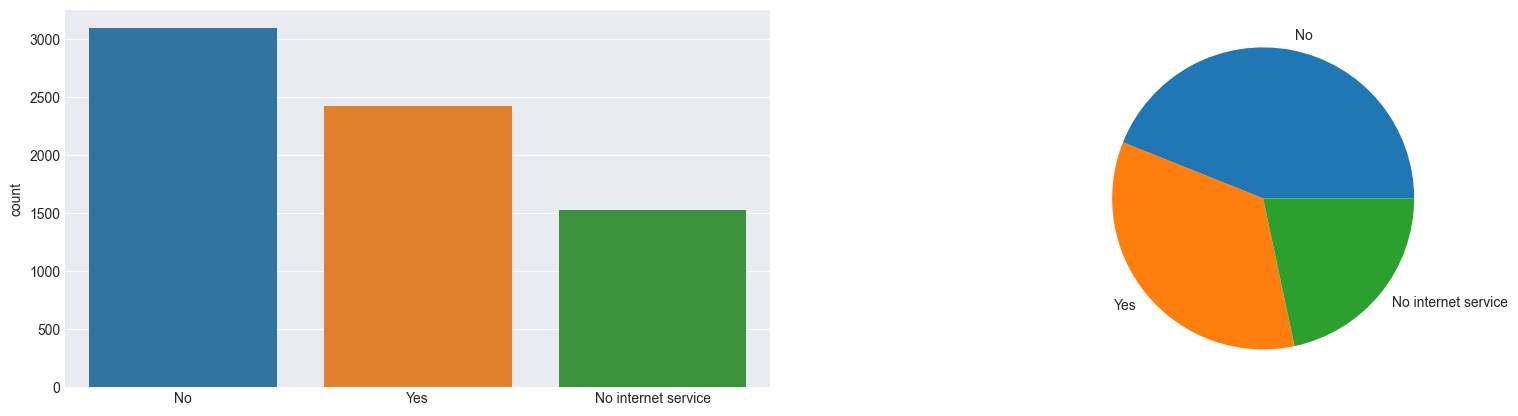

_____________________________________________________________________________________________________________________
				ANALYSIS OF: TechSupport 

No. of UNIQUE values:
No                     3473
Yes                    2044
No internet service    1526
Name: TechSupport, dtype: int64



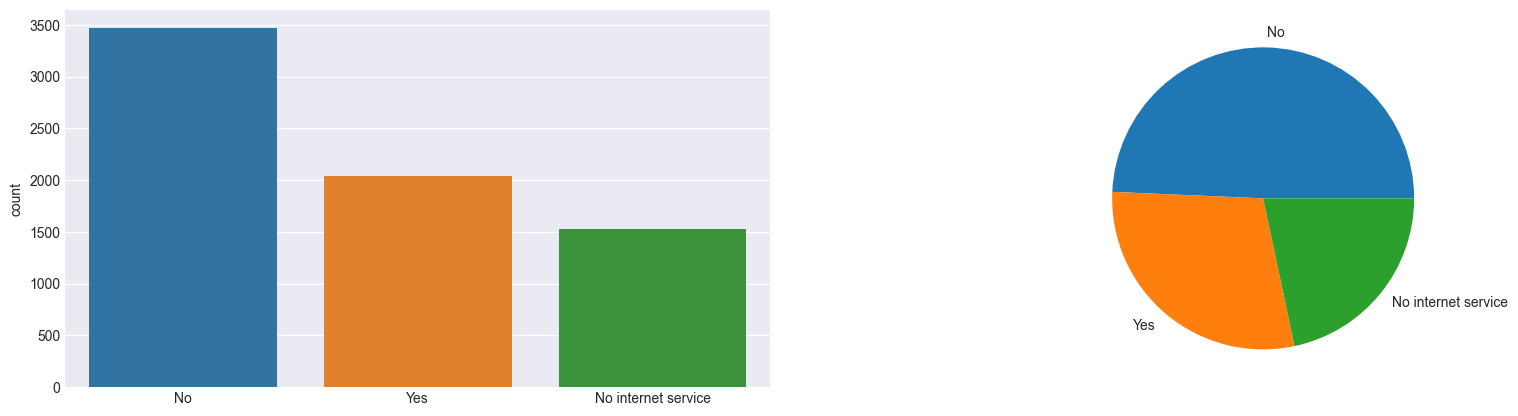

_____________________________________________________________________________________________________________________
				ANALYSIS OF: StreamingTV 

No. of UNIQUE values:
No                     2810
Yes                    2707
No internet service    1526
Name: StreamingTV, dtype: int64



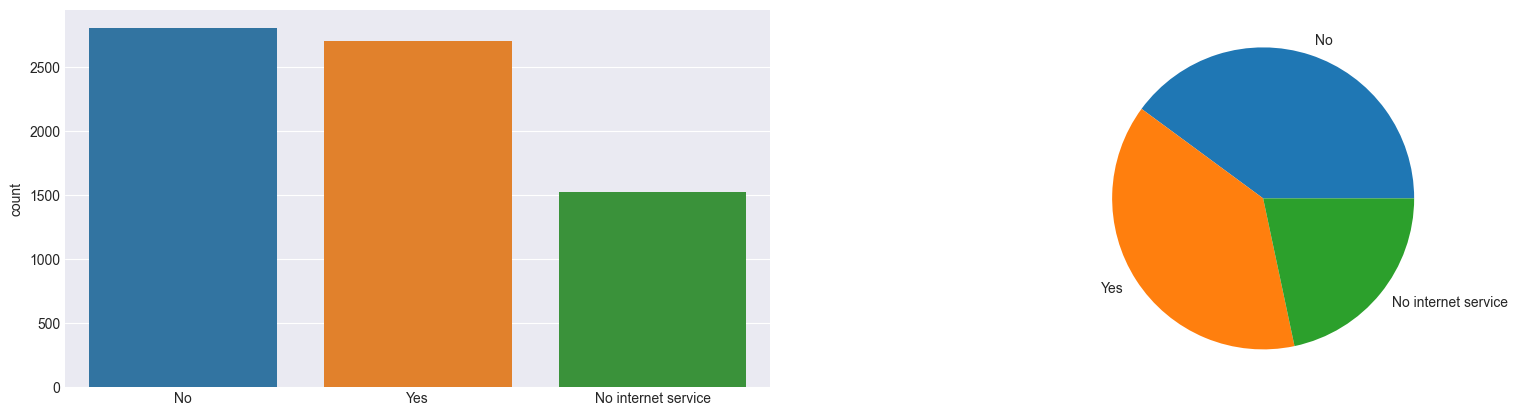

_____________________________________________________________________________________________________________________
				ANALYSIS OF: StreamingMovies 

No. of UNIQUE values:
No                     2785
Yes                    2732
No internet service    1526
Name: StreamingMovies, dtype: int64



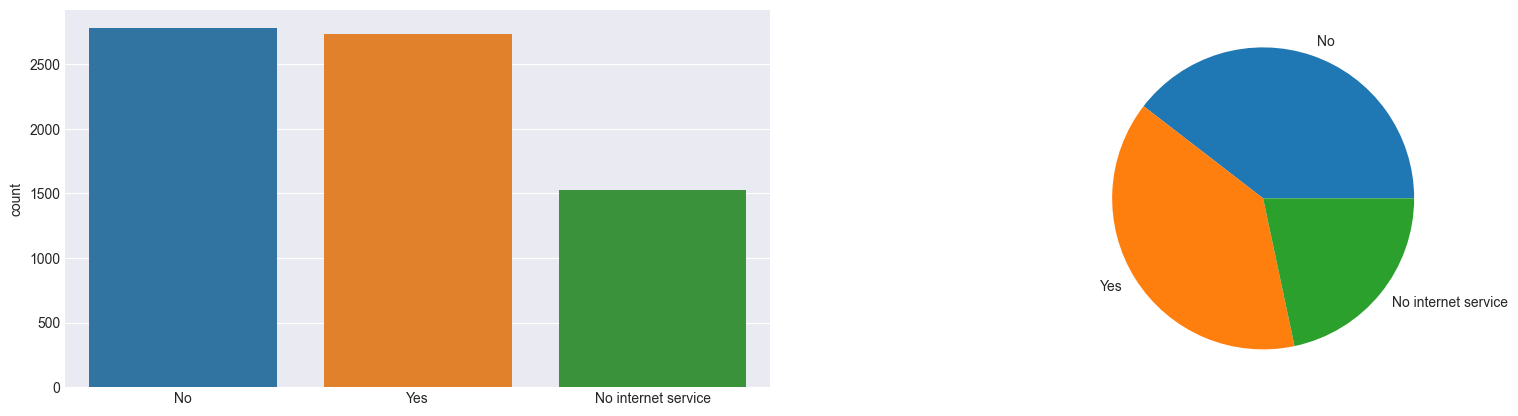

_____________________________________________________________________________________________________________________
				ANALYSIS OF: Contract 

No. of UNIQUE values:
Month-to-month    3875
Two year          1695
One year          1473
Name: Contract, dtype: int64



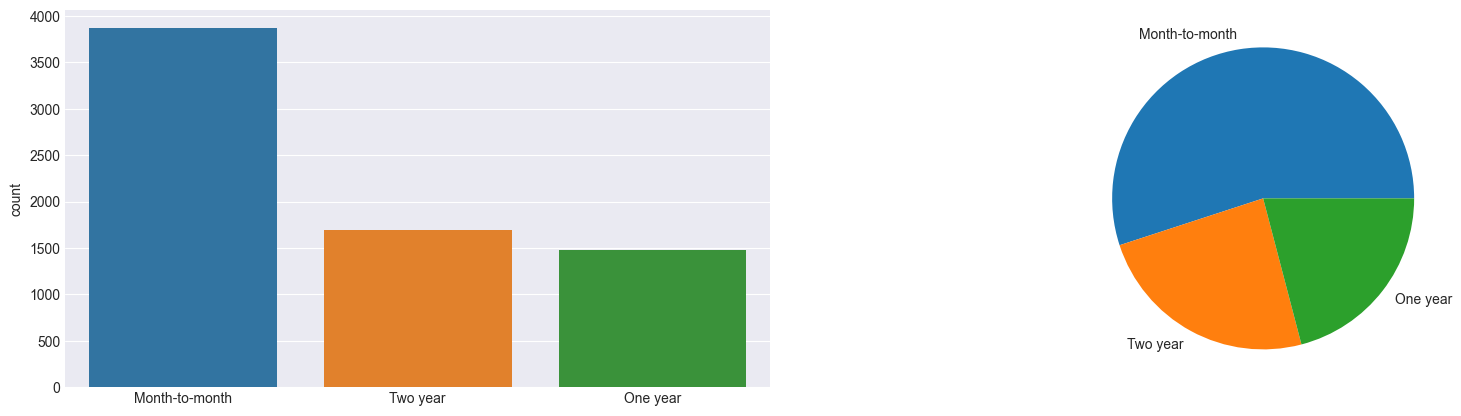

_____________________________________________________________________________________________________________________
				ANALYSIS OF: PaperlessBilling 

No. of UNIQUE values:
Yes    4171
No     2872
Name: PaperlessBilling, dtype: int64



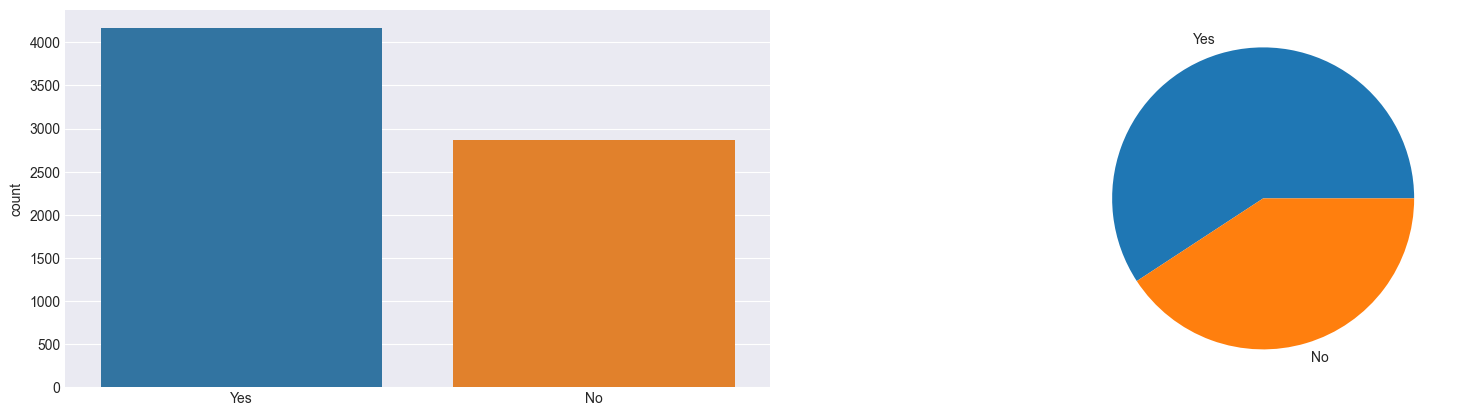

_____________________________________________________________________________________________________________________
				ANALYSIS OF: PaymentMethod 

No. of UNIQUE values:
Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64



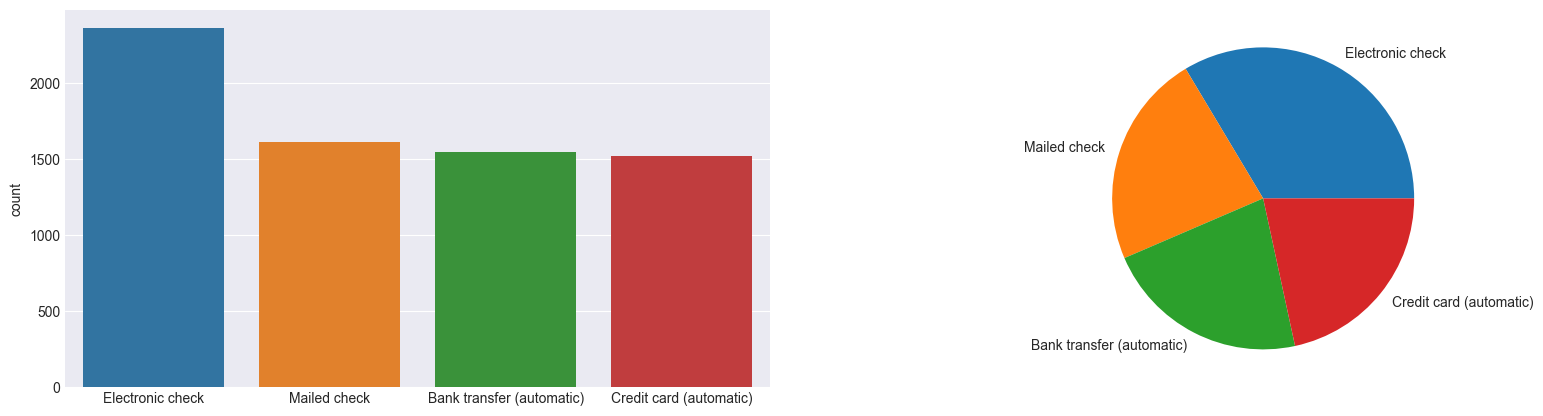

_____________________________________________________________________________________________________________________


In [16]:
analysis_cate(df, columns_cate, figsize=(20,5), dpi=100)

##### ***there are lot of categorical features, feature selection is needed***

### **BIVARIATE ANALYSIS**

### Correlation between features

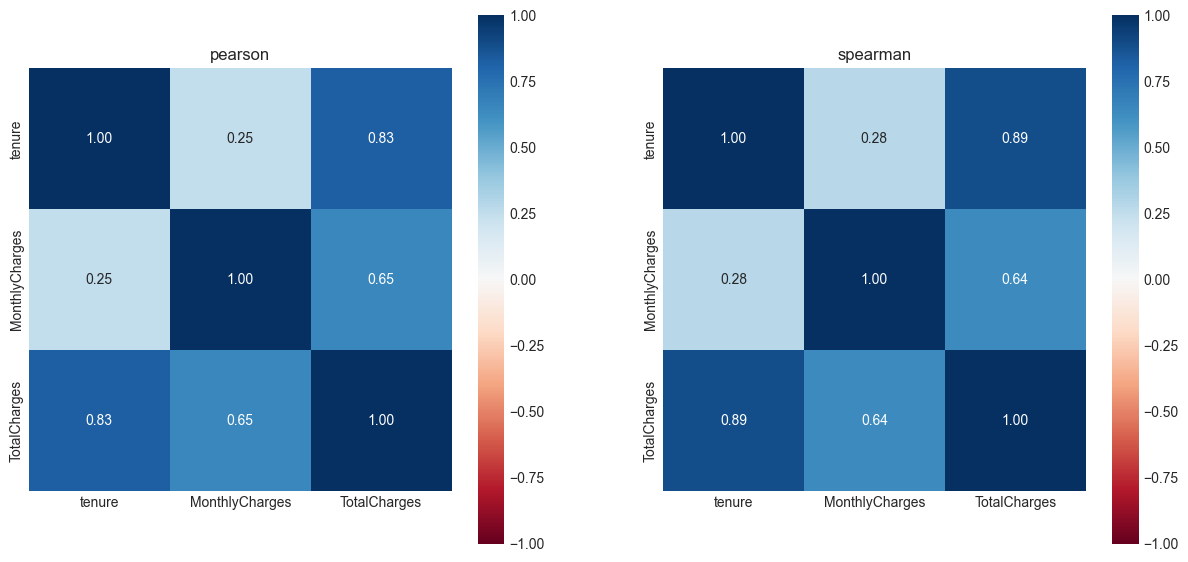

In [17]:
correlation(df.drop(columns='target', axis=1), figsize=(15,7), dpi=100)

##### ***TotalCharges seems to be highly correlated with tenure and MonthlyCharges***

### Lets see pairwise scatterplot

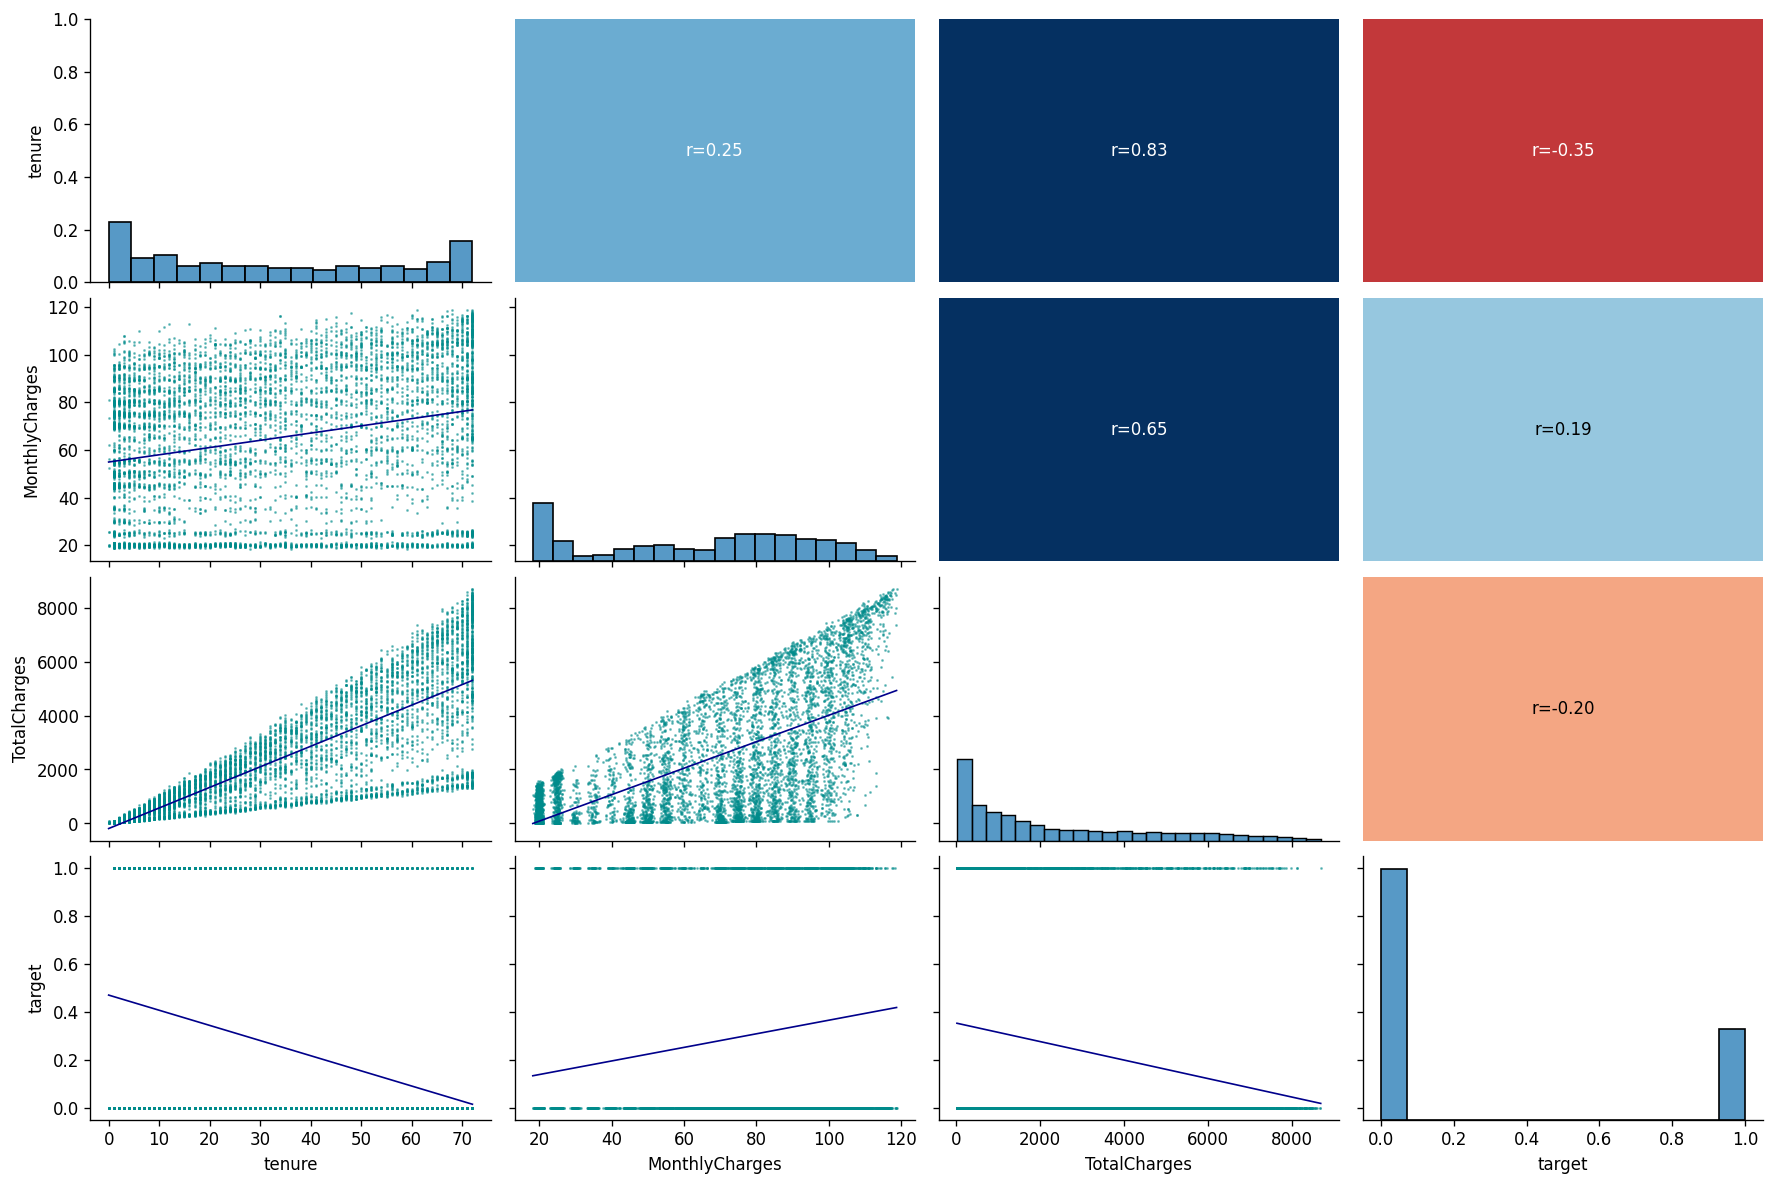

In [18]:
multiplot(df.loc[:,df.describe().columns], height=2.5, dpi=120)

### binning continuous features for easier analysis

In [19]:
from sklearn.preprocessing import KBinsDiscretizer
discrete=KBinsDiscretizer(n_bins=10,encode='ordinal', strategy='quantile')

df_num=df[columns_num]

df_num_binned=pd.DataFrame(discrete.fit_transform(df_num), index=df_num.index, columns=df_num.columns).add_suffix('_binned')
df_num_binned.head()

,tenure_binned,MonthlyCharges_binned,TotalCharges_binned
0,0.0,2.0,0.0
1,5.0,3.0,5.0
2,1.0,3.0,1.0
3,6.0,2.0,5.0
4,1.0,5.0,1.0


### adding binned features to dataframe

In [20]:
df=pd.concat( [df, df_num_binned], axis=1, join='inner')

In [21]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target,tenure_binned,MonthlyCharges_binned,TotalCharges_binned
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,0.0,2.0,0.0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0,5.0,3.0,5.0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,1.0,3.0,1.0
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,6.0,2.0,5.0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,1.0,5.0,1.0


### analysing continuous features  

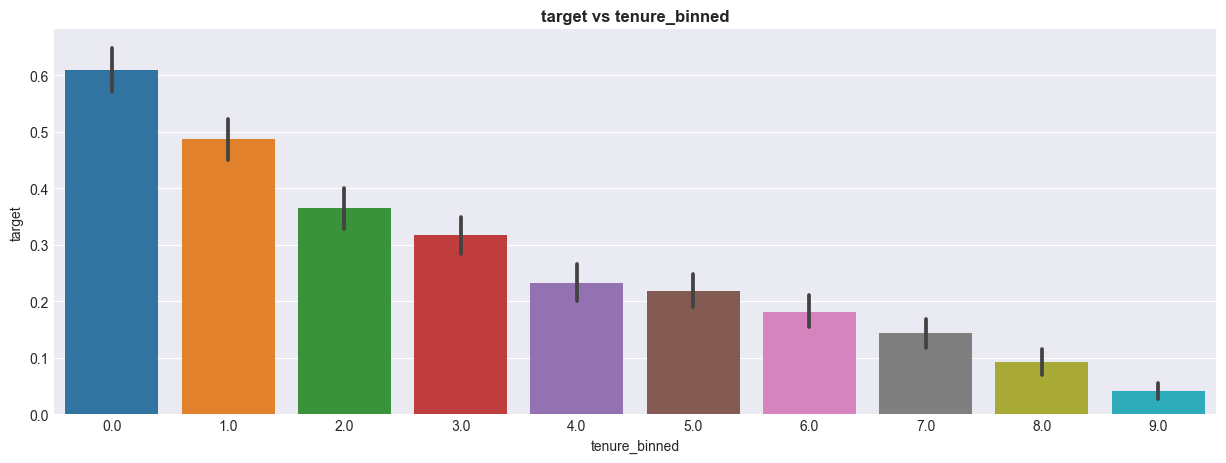

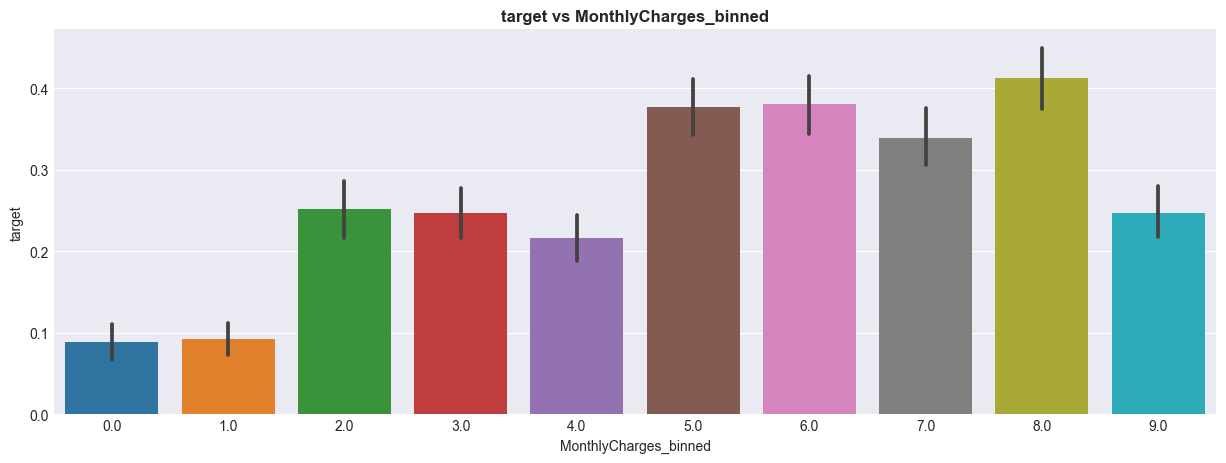

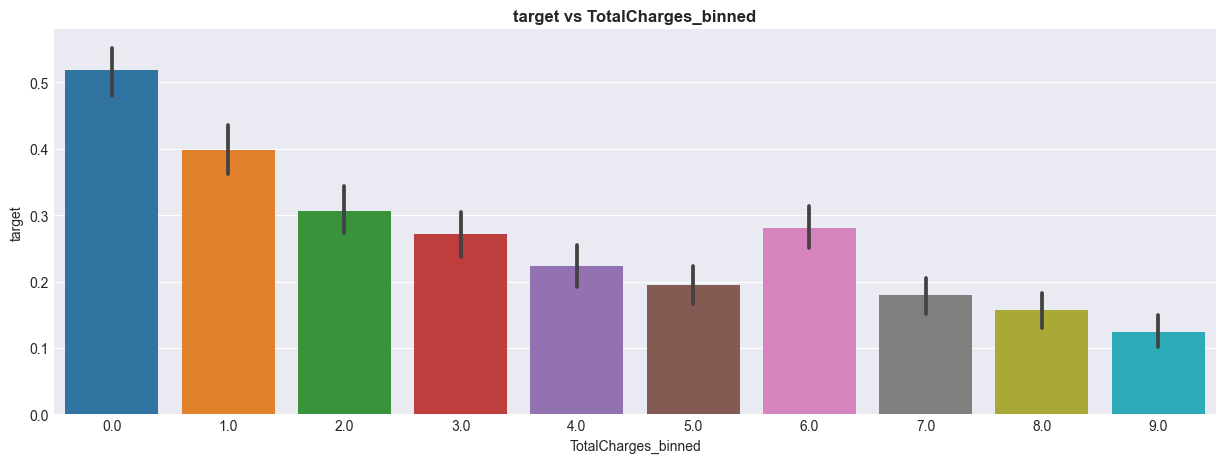

In [22]:
for col in df_num_binned.columns:
    plt.figure(figsize=(15,5), dpi=100)
    plt.title(f'target vs {col}', fontweight='bold')
    sns.barplot(x=col, y="target", data=df, estimator=np.mean )
    plt.show()

+ ***lower tenure seems to increase churn rate***
+ ***higher MonthlyCharges seems to increase churn rate***
+ ***interestingly lower TotalCharges seems to increase churn rate***

### analysing discrete features

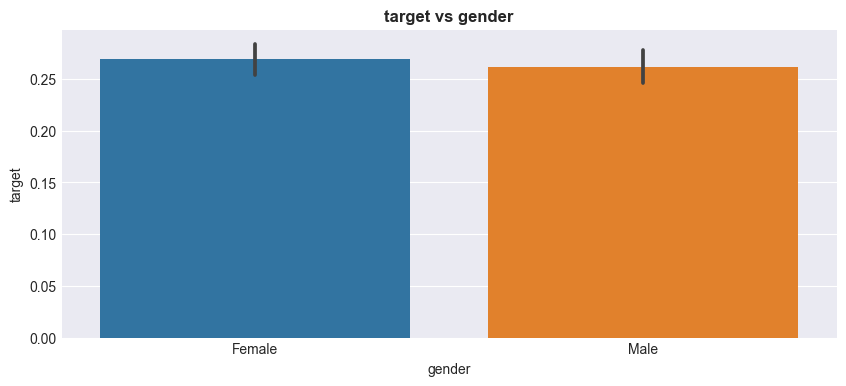

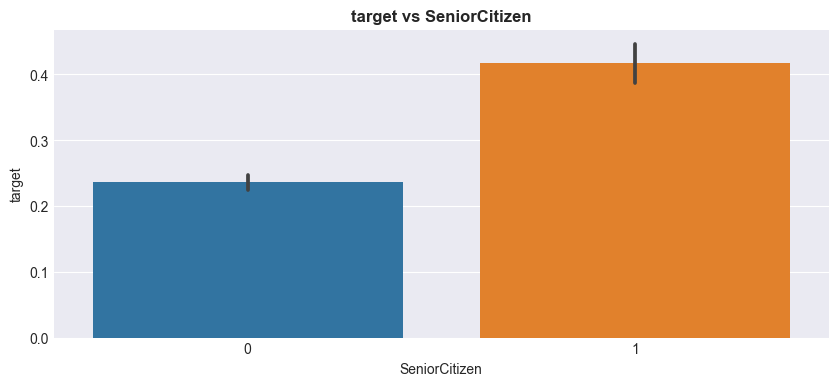

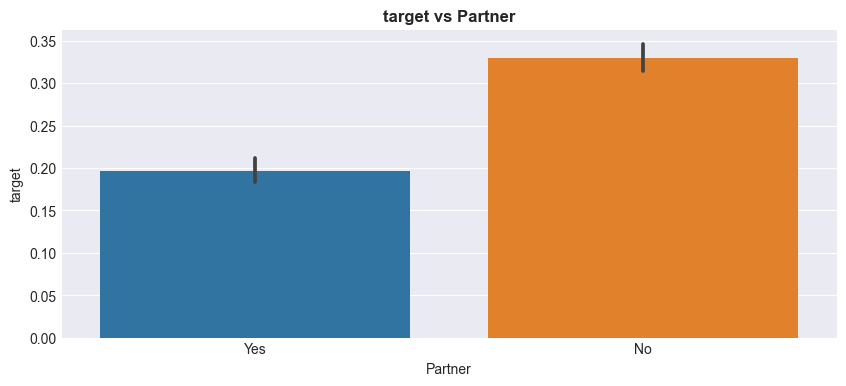

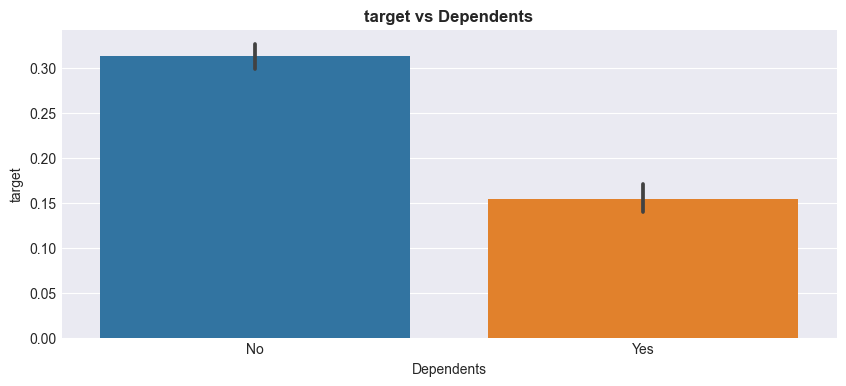

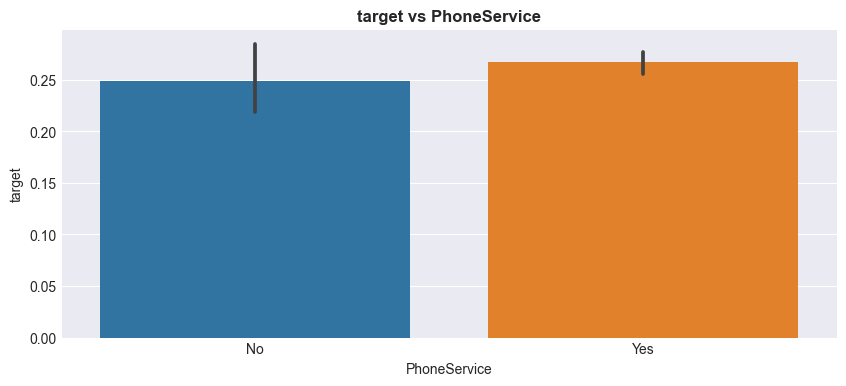

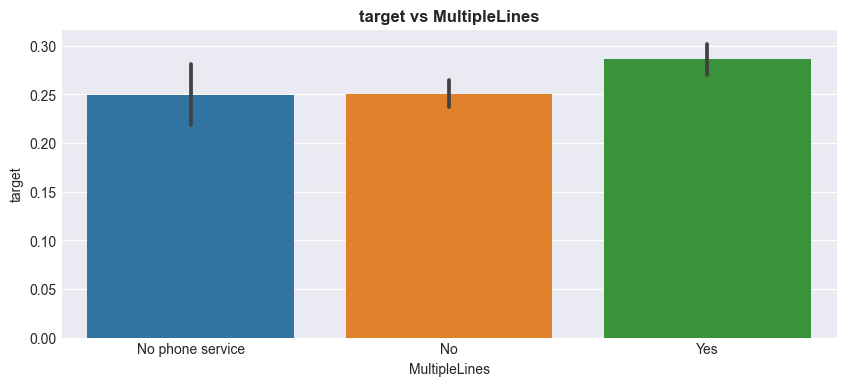

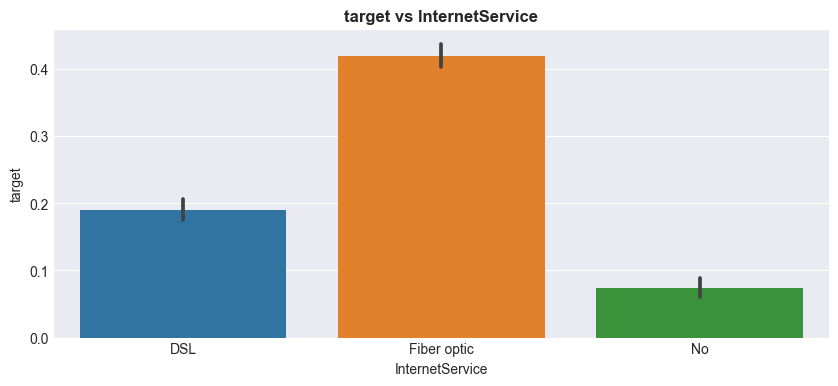

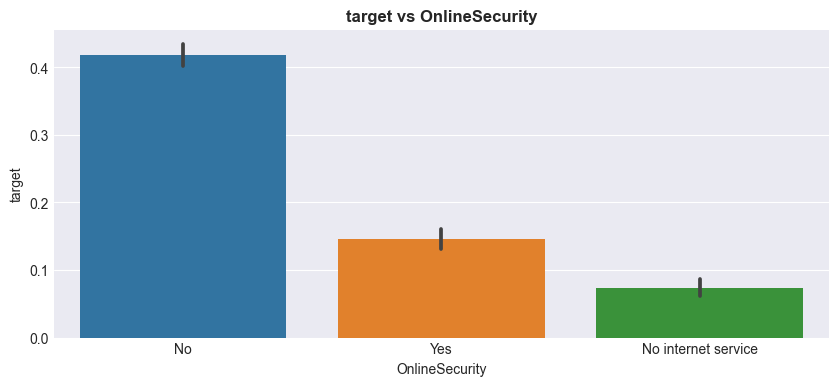

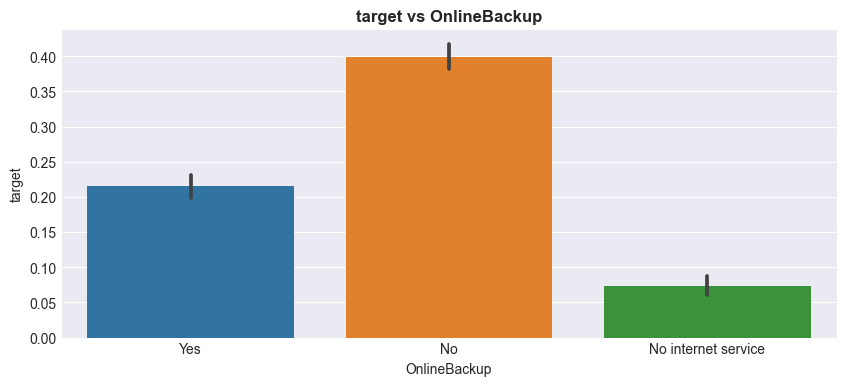

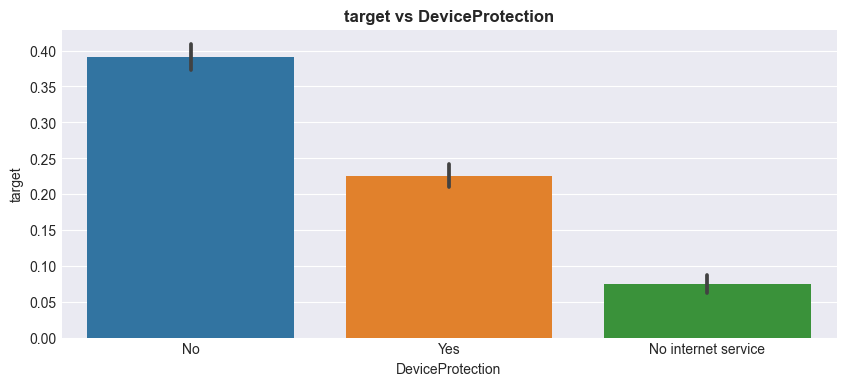

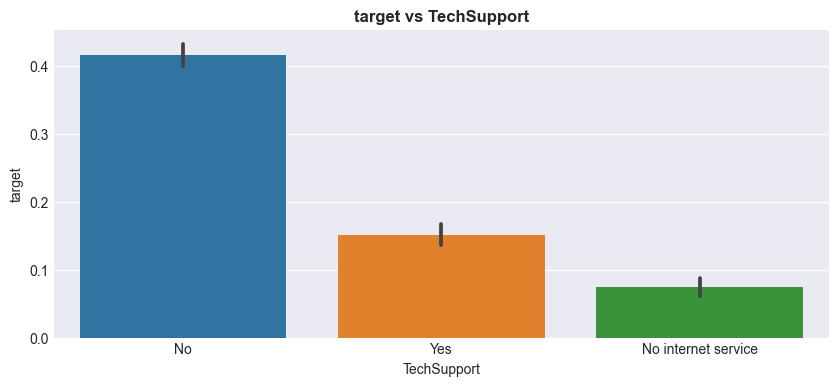

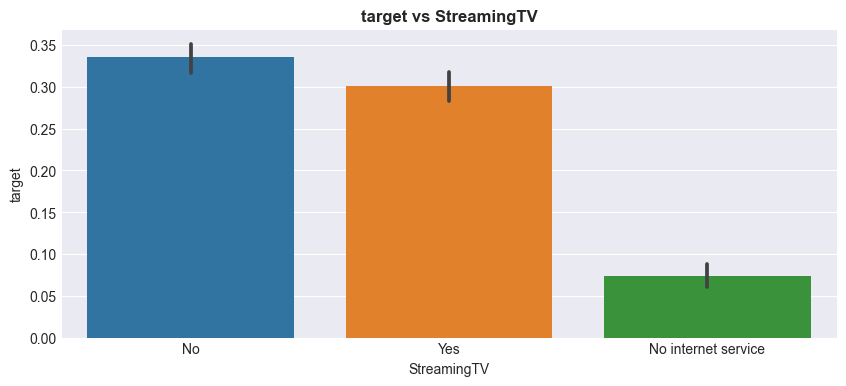

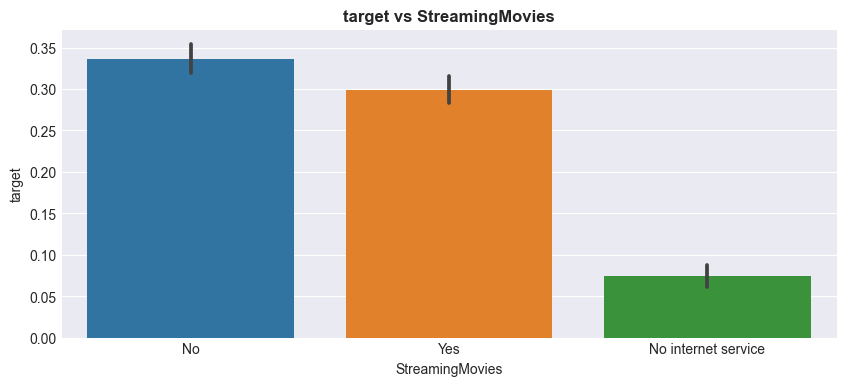

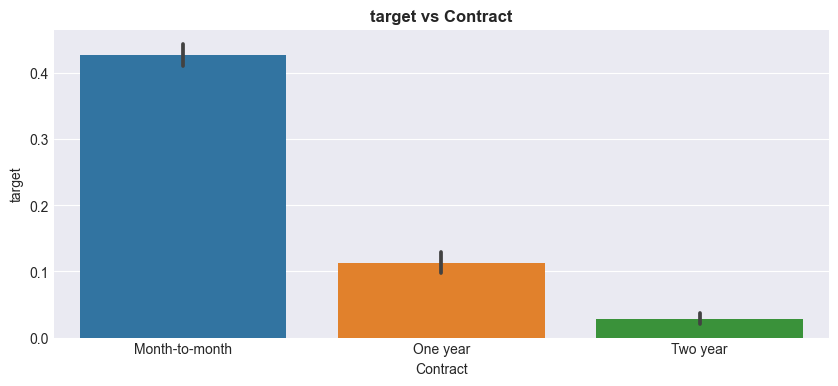

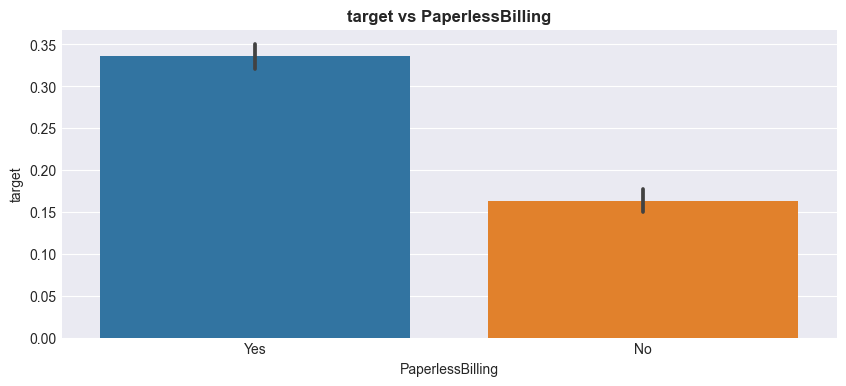

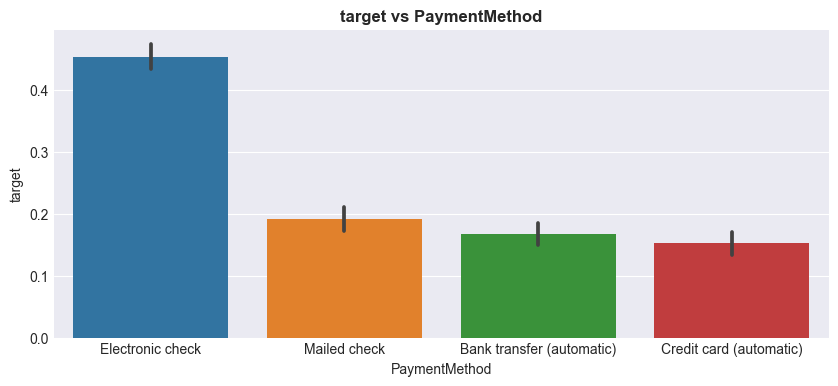

In [23]:
for col in columns_cate:
    plt.figure(figsize=(10,4), dpi=100 )
    plt.title(f'target vs {col}', fontweight='bold')
    sns.barplot(x=col, y="target", data=df, estimator=np.mean )
    plt.show()

*factors like being a **senior citizen, having no partners or dependents, no online security, no online backup,
</br>no device protection, no tech support, monthly contract, paperless billing, electronic check** seem to **increase churn rate***

### dropping certain columns because there is not much difference in churn rate for each of the classes in these features

In [24]:
# drop_cate_cols=['gender','PhoneService','MultipleLines']
# columns_cate_final=[i for i in columns_cate if i not in drop_cate_cols]
columns_cate_final=columns_cate

### separating features and label

In [25]:
X=df.drop('target', axis=1)
y=df.target

In [26]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target,tenure_binned,MonthlyCharges_binned,TotalCharges_binned
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,0.0,2.0,0.0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0,5.0,3.0,5.0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,1.0,3.0,1.0
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,6.0,2.0,5.0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,1.0,5.0,1.0


### train test split

In [27]:
# although CV score is being used, this split is needed for making confusion matrix
xtrain,xtest,ytrain,ytest=train_test_split(X,y)

# PIPELINES

### creating preprocessor pipeline

In [28]:
# transforming numerical features by scaling
numeric_transformer = MinMaxScaler()

# transforming categorical features using onehot encoder
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

# final preprocessor
preprocessor = ColumnTransformer(transformers=
                                 [( "numeric", numeric_transformer, columns_num ),
                                  ( "categorical", categorical_transformer, columns_cate_final )
                                 ]
)


### defining models

In [29]:
model_lr=LogisticRegression(n_jobs=-1, C=0.07)

model_dt=DecisionTreeClassifier(max_depth=6, min_samples_split=50 )   

model_rf=RandomForestClassifier(n_jobs=-1, max_features=0.5, max_depth=6, min_samples_split=50)    

model_ada_dt=AdaBoostClassifier( base_estimator=DecisionTreeClassifier(max_depth=6, min_samples_split=50), n_estimators=100, learning_rate=5)   

model_ada_rf=AdaBoostClassifier(base_estimator=RandomForestClassifier(n_jobs=-1, max_features=0.5, max_depth=6, min_samples_split=50), n_estimators=50, learning_rate=0.1)  

model_gb=GradientBoostingClassifier(max_depth=6, min_samples_split=50)

model_svc=SVC(C=0.1, degree=5 )   

model_mnb=MultinomialNB()

model_knc=KNeighborsClassifier(n_neighbors=5, n_jobs=-1, weights='distance')   

model_rnc=RadiusNeighborsClassifier(radius=10, n_jobs=-1, weights='distance')  

model_xgb=XGBClassifier(n_estimators=500, learning_rate=0.1, n_jobs=-1)

# dictionary of all models
models={'logistic':model_lr, 'decision tree':model_dt, 'random forest':model_rf, 'adaboost using dt':model_ada_dt, 'adaboost using rf':model_ada_rf,
        'gradboost':model_gb, 'SVC':model_svc, 'GaussianNB':model_mnb, 'KNC':model_knc, 'RNC':model_rnc, 'xgboost':model_xgb }

### pipeline and scores

LOGISTIC
train score:  0.8032942067398713
test score:  0.8029528676888131
cross validation f1 score: 0.5894342979919294
classification report:
               precision    recall  f1-score   support

           0       0.84      0.91      0.87      1280
           1       0.68      0.53      0.59       481

    accuracy                           0.80      1761
   macro avg       0.76      0.72      0.73      1761
weighted avg       0.79      0.80      0.79      1761



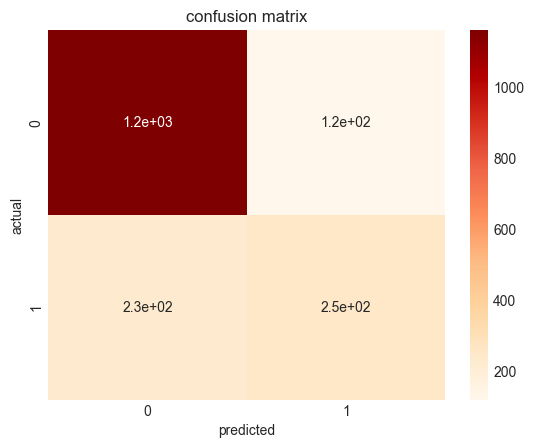

__________________________________________________________________________
DECISION TREE
train score:  0.8167360848163574
test score:  0.7796706416808632
cross validation f1 score: 0.5775226344127734
classification report:
               precision    recall  f1-score   support

           0       0.82      0.89      0.85      1280
           1       0.62      0.49      0.55       481

    accuracy                           0.78      1761
   macro avg       0.72      0.69      0.70      1761
weighted avg       0.77      0.78      0.77      1761



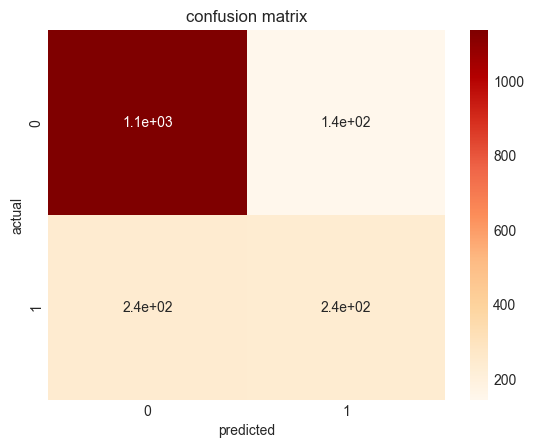

__________________________________________________________________________
RANDOM FOREST
train score:  0.8195759182127982
test score:  0.7955706984667802
cross validation f1 score: 0.5762211184303314
classification report:
               precision    recall  f1-score   support

           0       0.82      0.91      0.87      1280
           1       0.68      0.48      0.56       481

    accuracy                           0.80      1761
   macro avg       0.75      0.70      0.71      1761
weighted avg       0.78      0.80      0.78      1761



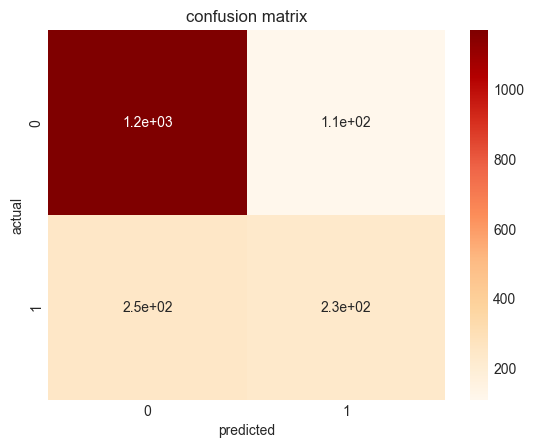

__________________________________________________________________________
ADABOOST USING DT
train score:  0.7430897387353276
test score:  0.7319704713231119
cross validation f1 score: 0.31367371392799603
classification report:
               precision    recall  f1-score   support

           0       0.73      0.99      0.84      1280
           1       0.70      0.03      0.06       481

    accuracy                           0.73      1761
   macro avg       0.71      0.51      0.45      1761
weighted avg       0.72      0.73      0.63      1761



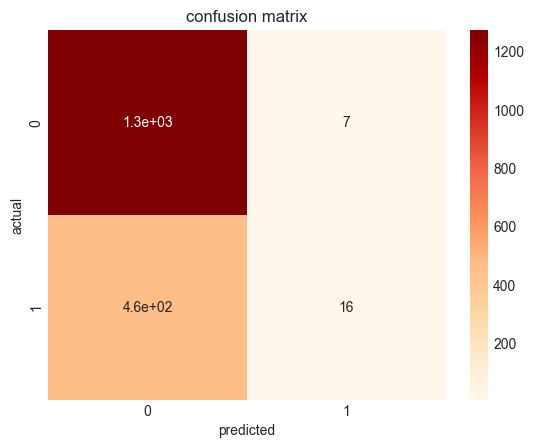

__________________________________________________________________________
ADABOOST USING RF
train score:  0.8424839076107535
test score:  0.8006814310051107
cross validation f1 score: 0.5829981966901445
classification report:
               precision    recall  f1-score   support

           0       0.83      0.91      0.87      1280
           1       0.68      0.50      0.58       481

    accuracy                           0.80      1761
   macro avg       0.76      0.71      0.72      1761
weighted avg       0.79      0.80      0.79      1761



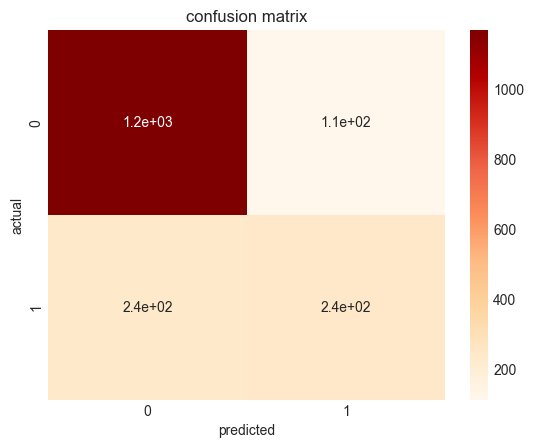

__________________________________________________________________________
GRADBOOST
train score:  0.878833775085195
test score:  0.7853492333901193
cross validation f1 score: 0.5793963460246545
classification report:
               precision    recall  f1-score   support

           0       0.83      0.89      0.86      1280
           1       0.63      0.51      0.56       481

    accuracy                           0.79      1761
   macro avg       0.73      0.70      0.71      1761
weighted avg       0.77      0.79      0.78      1761



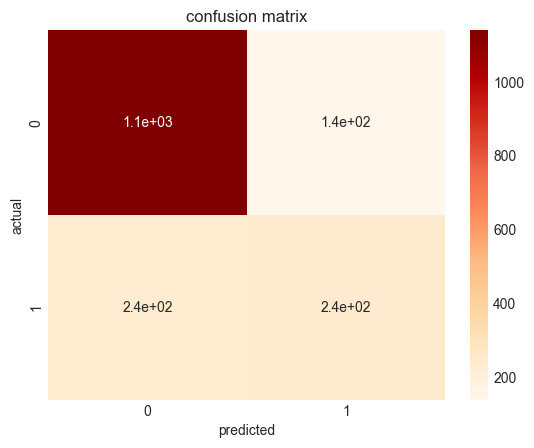

__________________________________________________________________________
SVC
train score:  0.7970465732677017
test score:  0.7864849517319704
cross validation f1 score: 0.5104067367844911
classification report:
               precision    recall  f1-score   support

           0       0.81      0.93      0.86      1280
           1       0.69      0.40      0.51       481

    accuracy                           0.79      1761
   macro avg       0.75      0.67      0.69      1761
weighted avg       0.77      0.79      0.77      1761



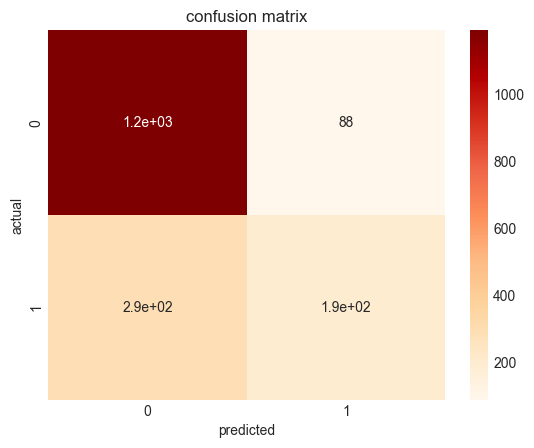

__________________________________________________________________________
GAUSSIANNB
train score:  0.724536160545248
test score:  0.7155025553662692
cross validation f1 score: 0.6042831923097856
classification report:
               precision    recall  f1-score   support

           0       0.90      0.69      0.78      1280
           1       0.49      0.79      0.60       481

    accuracy                           0.72      1761
   macro avg       0.69      0.74      0.69      1761
weighted avg       0.79      0.72      0.73      1761



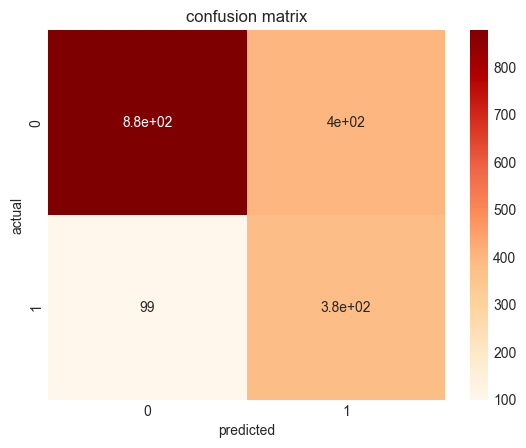

__________________________________________________________________________
KNC
train score:  0.9981067777357062
test score:  0.7331061896649631
cross validation f1 score: 0.5070683354927261
classification report:
               precision    recall  f1-score   support

           0       0.81      0.83      0.82      1280
           1       0.51      0.47      0.49       481

    accuracy                           0.73      1761
   macro avg       0.66      0.65      0.66      1761
weighted avg       0.73      0.73      0.73      1761



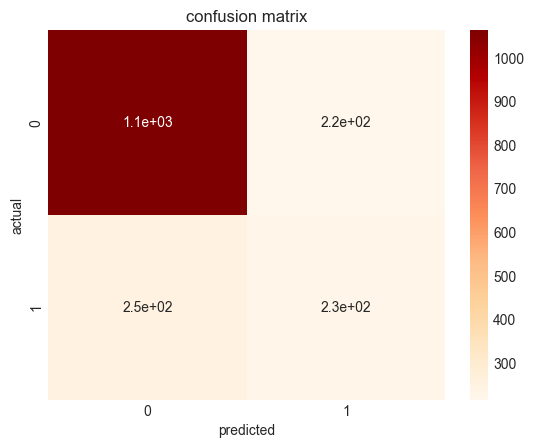

__________________________________________________________________________
RNC
train score:  0.9981067777357062
test score:  0.7296990346394094
cross validation f1 score: 0.06492020528904077
classification report:
               precision    recall  f1-score   support

           0       0.73      0.99      0.84      1280
           1       0.61      0.03      0.06       481

    accuracy                           0.73      1761
   macro avg       0.67      0.51      0.45      1761
weighted avg       0.70      0.73      0.63      1761



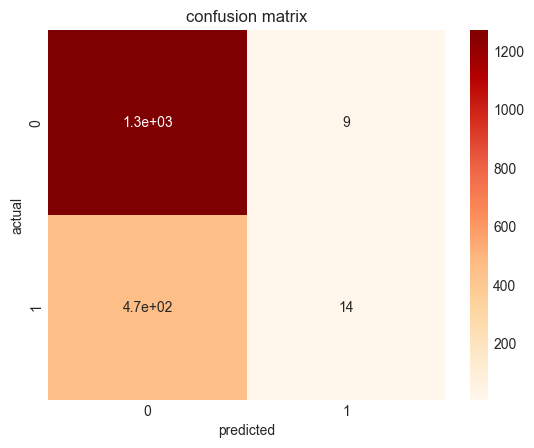

__________________________________________________________________________
XGBOOST
train score:  0.9716016660355926
test score:  0.7893242475865985
cross validation f1 score: 0.5624348956830929
classification report:
               precision    recall  f1-score   support

           0       0.83      0.89      0.86      1280
           1       0.64      0.52      0.57       481

    accuracy                           0.79      1761
   macro avg       0.74      0.70      0.72      1761
weighted avg       0.78      0.79      0.78      1761



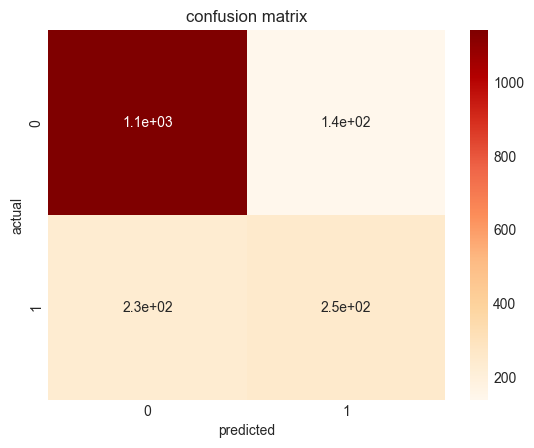

__________________________________________________________________________


In [30]:
pipelines=[]
f1={}

for name,model in models.items():
    
    # making pipeline for each model
    pipeline = Pipeline(steps=[("preprocessor", preprocessor),
                               ("classifier", model)
                              ]
                       )
    
    # print name of pipeline
    print(name.upper())
    
    # fitting data
    pipeline.fit(xtrain,ytrain)
    
    # calculating scores and storing
    score_cv=np.mean(cross_val_score(pipeline, X, y, cv=5, scoring='f1'))
    f1[name]=score_cv
    
    # printing scores
    print('train score: ', pipeline.score(xtrain,ytrain) )
    print('test score: ', pipeline.score(xtest,ytest) )
    print('cross validation f1 score:', score_cv)
    print('classification report:\n', classification_report(ytest,pipeline.predict(xtest)) )
    
    #confusion matrix
    sns.heatmap( confusion_matrix(ytest,pipeline.predict(xtest)), annot=True, cmap='OrRd' )
    plt.xlabel('predicted')
    plt.ylabel('actual')
    plt.title('confusion matrix')
    plt.show()
    
    print('__________________________________________________________________________')
    

### model scores comparison

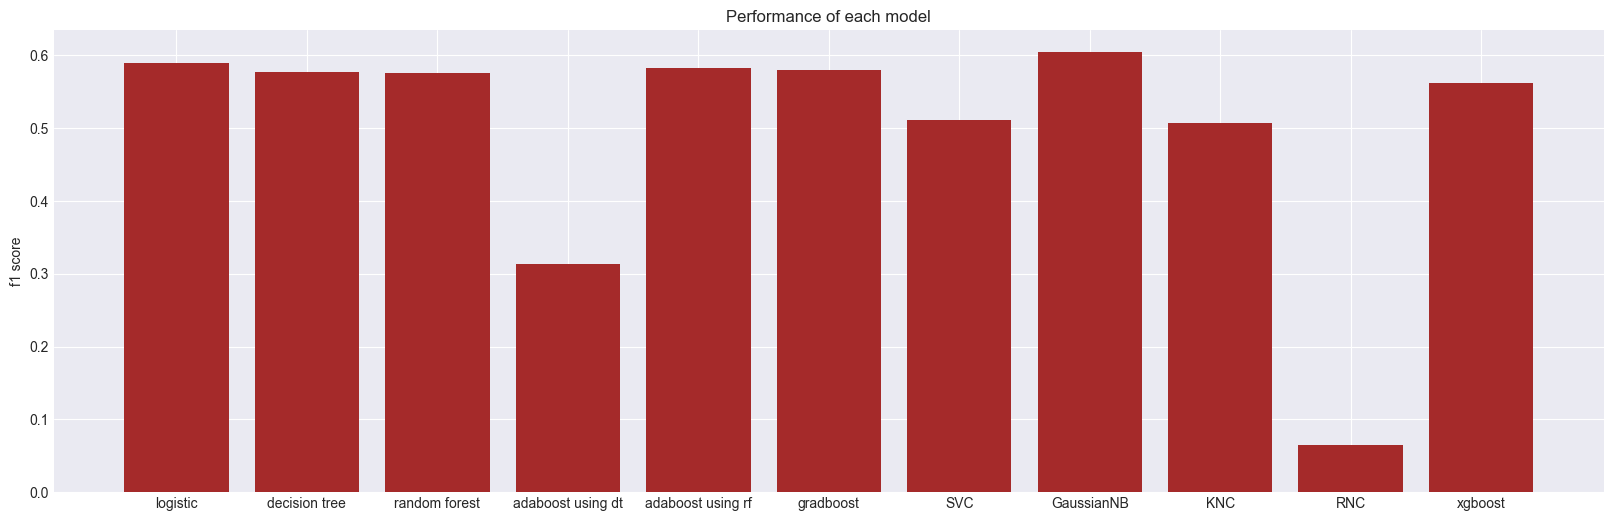

In [31]:
plt.figure(figsize=(20,6), dpi=100)
plt.bar( f1.keys(),f1.values(), color='brown', )
plt.ylabel('f1 score')
plt.title('Performance of each model')
plt.show()

    most of the models seem to be predicting no churn easily
    whereas they are unable to predict the churn happening
### ***This is mostly due to imbalanced classes and the lower occuring class needs to be balanced***